# Prototype for MC matching based on minimum angle between genParticle and pfcharged

In this example, `ak.cartesian()` is used to make pairs of MC-truth generated particles (from `genParticles`) and reconstructed hadrons (from `pfcharged`). A cut is applied on the `pdgId` such that only pairs with the same generator and reco `pdgId` are considered. The cosine of the angle between the generated and reco particles is calculated, and used as a metric for picking the best pair. The generated information is then associated to the reco information for each reco hadron, allowing quantities like $\delta(p)$ to be calculated. 

The code is based on the example found in [this](https://github.com/jpivarski-talks/2020-04-08-eic-jlab/blob/master/2020-04-08-eic-jlab-EVALUATED.ipynb) `awkward array` tutorial, where brem photons are associated to electrons. 

In [1]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics
from particle import literals as lp
from fcc_python_tools import plotting

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

file = uproot.open(f"{loc.DATA}/FCCDelphesOutput.root")
tree = file['events']

Get the reconstructed stable hadrons:

In [2]:
h_container = "pfcharged.core"
h = tree.arrays(filter_name=f"{h_container}*",how="zip")
h[h_container,'p4.p'] = kinematics.calc_p(h,h_container)

Get the generated particles:

In [3]:
g_container = "genParticles.core"
g = tree.arrays(filter_name=f"{g_container}*",how="zip")
g[g_container,'p4.p'] = kinematics.calc_p(g,g_container)

Make pairs of reco and gen particles across all events:

In [4]:
pairs = ak.cartesian({"reco": h[h_container], "gen": g[g_container]}, nested=True)

Require that the `pdgId` of the particles are the same:

In [5]:
ID_cut = pairs["reco","pdgId"] == pairs["gen","pdgId"]
pairs = pairs[ID_cut]

Calculate $\cos(\theta)$ between the reco and true particles, which we will use as a matching requirement:

In [6]:
pairs["costheta"] = kinematics.cos_angle(pairs["reco"], pairs["gen"])

/Users/dhill/miniconda/envs/fcc_pyenv/lib/python3.7/site-packages/awkward1/_connect/_numpy.py:101: RuntimeWarning: invalid value encountered in true_divide
  *[nplike.asarray(x) for x in inputs], **kwargs


Pick best pair according to $\cos(\theta)_{max}$ i.e. minimum angle:

In [7]:
best_pair = pairs[ak.singletons(ak.argmax(pairs["costheta"], axis=2))]

Associate the best gen particle with the reco particle:

In [8]:
h["match"] = ak.firsts(best_pair, axis=2)

Can get the reco info using `h["match","reco","var_name"]` and the corresponding MC-truth value with `h["match","gen","var_name"]`. So can calculate a resolution like this:

In [9]:
h["delta_p"] = h["match","reco","p4.p"] - h["match","gen","p4.p"]

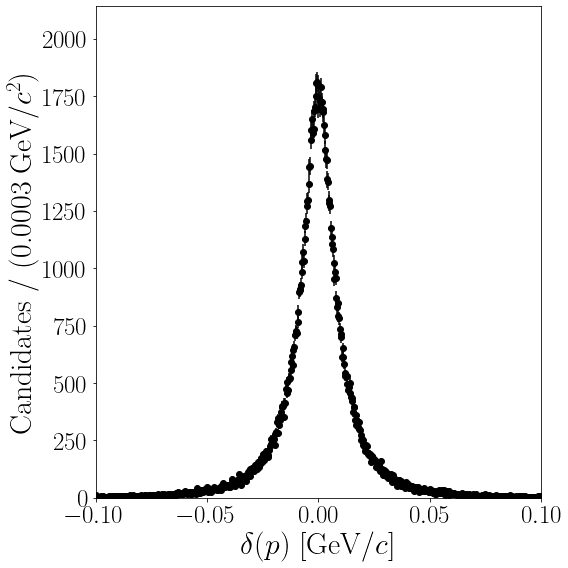

In [10]:
low = -0.1
high = 0.1
plotting.errorbar_hist(h,"delta_p","all_hadrons","$\delta(p)$ [GeV/$c$]",low,high)